In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm import tqdm
import numpy as np
import sys
import time
import shutil
sys.path.append(r'C:\Users\hansm\Github\CIS472-CourseProject\models')
from lenet import LeNet
sys.path.pop()
sys.path.append(r'C:\Users\hansm\Github\CIS472-CourseProject\training')
from training import train_epoch, evaluate
sys.path.pop()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Qut Fish Dataset

In [3]:
data_path = "C:\\Users\\hansm\\Github\\CIS472-CourseProject\\Project Datasets\\Dataset1\\QutFishDataset\\archive\\Fish_data"

In [4]:
# get all classes for the dataset
classes = []
classes_file = r"C:\Users\hansm\Github\CIS472-CourseProject\Project Datasets\Dataset1\QutFishDataset\archive\Fish_data\final_all_index.txt"
with open(classes_file) as classesf:
    for line in classesf:
        splitted_line = line.strip().split('=')
        cls = splitted_line[1]
        if cls not in classes:
            classes.append(cls)
        else:
            continue
    classesf.close()
num_classes = len(classes)
print(num_classes)

483


In [5]:
class QutFishDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.labels = []
        self.images = []
        index_file = f"{self.data_path}\\final_all_index.txt"
        with open(index_file) as indexf:
            for line in indexf:
                splitted_line = line.strip().split('=')
                label = splitted_line[0]
                image = splitted_line[4] + ".png"
                self.labels.append(label)
                self.images.append(image)
            indexf.close()
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        img = Image.open(f"{self.data_path}\\images\\numbered\\{self.images[idx]}").convert("RGB")
        img = self.transform(img)
        label = torch.tensor(int(self.labels[idx]) - 1)
        return img, label

**Lenet Training for QUT Fish Dataset**

In [6]:
lenet = LeNet(num_classes)
lenetModel = lenet.to(device)
print(lenetModel)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=483, bias=True)
)


In [7]:
# hyperparameters
batch_size = 15
learning_rate=0.001
nepochs = 30

In [8]:
# transform
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
# Split dataset into train and test sets
fish_data = QutFishDataset(data_path=data_path, transform=transform)
train_size = int(0.8 * len(fish_data))
test_size = len(fish_data) - train_size
train_dataset, test_dataset = random_split(fish_data, [train_size, test_size])
print(len(train_dataset))
print(len(test_dataset))

3528
883


In [10]:
# train and test loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))

236


Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: torch.Size([15, 3, 32, 32]), torch.Size([15])
Labels: tensor([ 90, 186,  87, 136, 416, 186,  74, 220, 165, 364,  17, 137, 160, 349,
        481])



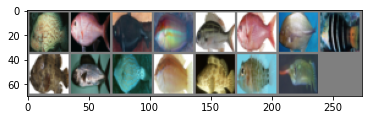

In [11]:
data = iter(train_loader) # iterate through data
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")
img_grid = make_grid(single_point[0])
matplotlib_imshow(img_grid)

In [12]:
# Adam optimizer
optimizer = optim.Adam(lenetModel.parameters(), lr=learning_rate)

# loss function
LossFunction = nn.CrossEntropyLoss()

for epoch in range(nepochs):
    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        output = lenetModel(inputs)
        loss = LossFunction(output, labels)
        loss.backward()
        optimizer.step()
        
        end_time = time.time()
        elapsed_time = (end_time - start_time)/60
        running_loss += loss.item()
        if (i+1) % 20 == 0:
            print('[epoch: %d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
            print(f"Time: {elapsed_time} min")
            running_loss = 0.0
    print()

print("Lenet Finished Training for QUT Fish Dataset")

[epoch: 1,    20] loss: 6.186
Time: 0.025175070762634276 min
[epoch: 1,    40] loss: 6.172
Time: 0.04986468156178792 min
[epoch: 1,    60] loss: 6.183
Time: 0.08349535862604777 min
[epoch: 1,    80] loss: 6.168
Time: 0.10654794375101725 min
[epoch: 1,   100] loss: 6.153
Time: 0.13172833522160848 min
[epoch: 1,   120] loss: 6.157
Time: 0.17691946427027386 min
[epoch: 1,   140] loss: 6.159
Time: 0.20403834184010824 min
[epoch: 1,   160] loss: 6.120
Time: 0.23400513331095377 min
[epoch: 1,   180] loss: 6.055
Time: 0.2644407391548157 min
[epoch: 1,   200] loss: 6.064
Time: 0.2949523448944092 min
[epoch: 1,   220] loss: 6.021
Time: 0.32508641878763833 min

[epoch: 2,    20] loss: 5.843
Time: 0.031978670756022134 min
[epoch: 2,    40] loss: 5.698
Time: 0.06218732198079427 min
[epoch: 2,    60] loss: 5.789
Time: 0.09280460675557455 min
[epoch: 2,    80] loss: 5.741
Time: 0.1227303385734558 min
[epoch: 2,   100] loss: 5.605
Time: 0.1557393511136373 min
[epoch: 2,   120] loss: 5.841
Time: 0.186

[epoch: 13,   120] loss: 1.799
Time: 0.18124839464823406 min
[epoch: 13,   140] loss: 1.696
Time: 0.2100764234860738 min
[epoch: 13,   160] loss: 1.664
Time: 0.24198227326075236 min
[epoch: 13,   180] loss: 1.660
Time: 0.27173373301823933 min
[epoch: 13,   200] loss: 1.910
Time: 0.3017048160235087 min
[epoch: 13,   220] loss: 1.761
Time: 0.3318566838900248 min

[epoch: 14,    20] loss: 1.238
Time: 0.030133819580078124 min
[epoch: 14,    40] loss: 1.382
Time: 0.06255687475204467 min
[epoch: 14,    60] loss: 1.392
Time: 0.09451222022374471 min
[epoch: 14,    80] loss: 1.371
Time: 0.12546205520629883 min
[epoch: 14,   100] loss: 1.505
Time: 0.1577576518058777 min
[epoch: 14,   120] loss: 1.686
Time: 0.18901463349660239 min
[epoch: 14,   140] loss: 1.430
Time: 0.21902220646540324 min
[epoch: 14,   160] loss: 1.524
Time: 0.251571798324585 min
[epoch: 14,   180] loss: 1.675
Time: 0.2816413442293803 min
[epoch: 14,   200] loss: 1.355
Time: 0.3120464166005453 min
[epoch: 14,   220] loss: 1.584

[epoch: 25,   180] loss: 0.280
Time: 0.28204535245895385 min
[epoch: 25,   200] loss: 0.322
Time: 0.31216243902842206 min
[epoch: 25,   220] loss: 0.358
Time: 0.34445550441741946 min

[epoch: 26,    20] loss: 0.219
Time: 0.03036339282989502 min
[epoch: 26,    40] loss: 0.342
Time: 0.06276466846466064 min
[epoch: 26,    60] loss: 0.337
Time: 0.09366665283838908 min
[epoch: 26,    80] loss: 0.275
Time: 0.12513343493143717 min
[epoch: 26,   100] loss: 0.224
Time: 0.15706581274668377 min
[epoch: 26,   120] loss: 0.245
Time: 0.1880921761194865 min
[epoch: 26,   140] loss: 0.246
Time: 0.21917343934377034 min
[epoch: 26,   160] loss: 0.322
Time: 0.25122546354929604 min
[epoch: 26,   180] loss: 0.393
Time: 0.28263232310612996 min
[epoch: 26,   200] loss: 0.444
Time: 0.31378102699915567 min
[epoch: 26,   220] loss: 0.455
Time: 0.3445244590441386 min

[epoch: 27,    20] loss: 0.265
Time: 0.030653015772501627 min
[epoch: 27,    40] loss: 0.298
Time: 0.0621842900911967 min
[epoch: 27,    60] loss:

In [13]:
lenet_accuracy = evaluate(lenetModel, test_loader)
print(f"Total accuracy for leNet for QUT Fish Dataset = {100 * lenet_accuracy / len(test_dataset):.2f}%")

Total accuracy for leNet for QUT Fish Dataset = 25.59%
